In [1]:
import typing
import gc
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import matplotlib.pyplot as plt

In [80]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
X_bool = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]
not_X = [not(e) for e in X_bool]
X_idx = [i for (i, e) in enumerate(X_bool) if e]

In [3]:
train, valid, test = (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :])

In [4]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_bool], train)
    Y_hat = lasso_model.predict(valid[:, X_bool])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.001
Computing validation loss for alpha = 0.004105263157894737
Computing validation loss for alpha = 0.007210526315789474
Computing validation loss for alpha = 0.010315789473684212
Computing validation loss for alpha = 0.013421052631578948
Computing validation loss for alpha = 0.016526315789473684
Computing validation loss for alpha = 0.019631578947368424
Computing validation loss for alpha = 0.02273684210526316
Computing validation loss for alpha = 0.025842105263157895
Computing validation loss for alpha = 0.02894736842105263
Computing validation loss for alpha = 0.03205263157894737
Computing validation loss for alpha = 0.0351578947368421
Computing validation loss for alpha = 0.038263157894736846
Computing validation loss for alpha = 0.04136842105263158
Computing validation loss for alpha = 0.04447368421052632
Computing validation loss for alpha = 0.047578947368421054
Computing validation loss for alpha = 0.05068421052631579
Computing validation

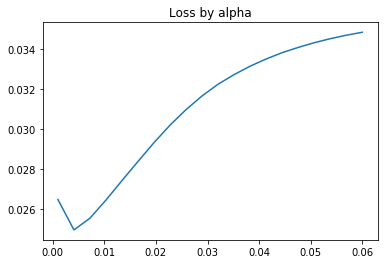

In [5]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [23]:
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_bool], train)

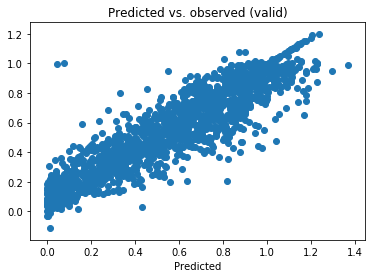

In [45]:
# plot predicted vs. observed
Y_hat = lasso_model.predict(valid[:, X_bool])
plt.scatter(valid[0], Y_hat[0])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid)");

In [26]:
Y_hat = lasso_model.predict(test[:, X_bool])
print("Final test loss (mse): {}".format(mean_squared_error(Y_hat, test)))

Final test loss (mse): 0.026553129235773236


### Why is regularisation making performance poorer?
Is X compressible?

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca_model = PCA().fit(train[:, X_bool])

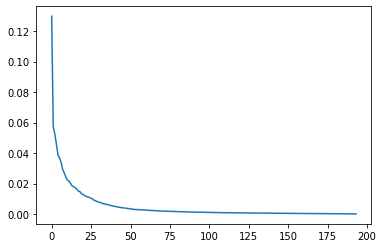

In [31]:
plt.plot(pca_model.explained_variance_ratio_)

In [32]:
# sanity check
sum(pca_model.explained_variance_ratio_)

1.0000000000000002

Look at the model coefficients

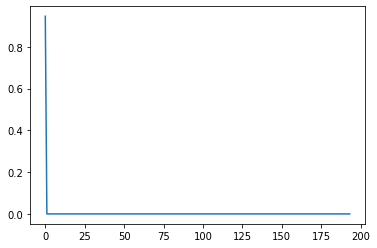

In [34]:
plt.plot(lasso_model.coef_[1])

**All the information is in variable 0!**

In [36]:
lasso_model_2 = Lasso().fit(train[:, X_idx[0]].reshape(train.shape[0],1), train)

In [37]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))

0.0355232717631723


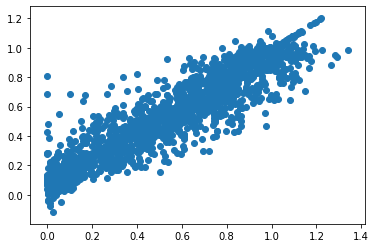

In [53]:
plt.scatter(valid[3], Y_hat[3]);

0.2324028307021928


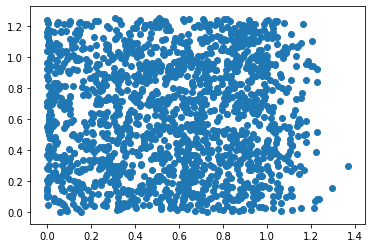

In [52]:
# what does random mse look like?
rand_pred = np.random.uniform(0, 1.25, size=valid.shape[1])
print(mean_squared_error(rand_pred, valid[0]))
plt.scatter(valid[0], rand_pred);

Let's try without variable 0

In [93]:
X_idx = X_idx[1:]

In [57]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_idx], train)
    Y_hat = lasso_model.predict(valid[:, X_idx])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.001
Computing validation loss for alpha = 0.004105263157894737
Computing validation loss for alpha = 0.007210526315789474
Computing validation loss for alpha = 0.010315789473684212
Computing validation loss for alpha = 0.013421052631578948
Computing validation loss for alpha = 0.016526315789473684
Computing validation loss for alpha = 0.019631578947368424
Computing validation loss for alpha = 0.02273684210526316
Computing validation loss for alpha = 0.025842105263157895
Computing validation loss for alpha = 0.02894736842105263
Computing validation loss for alpha = 0.03205263157894737
Computing validation loss for alpha = 0.0351578947368421
Computing validation loss for alpha = 0.038263157894736846
Computing validation loss for alpha = 0.04136842105263158
Computing validation loss for alpha = 0.04447368421052632
Computing validation loss for alpha = 0.047578947368421054
Computing validation loss for alpha = 0.05068421052631579
Computing validation

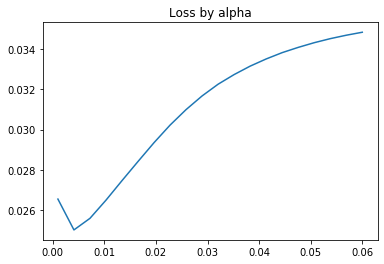

In [58]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [68]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

Create a lasso model using alpha = 0.004105263157894737


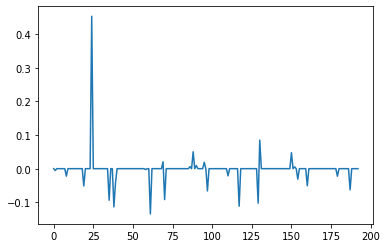

In [69]:
plt.plot(lasso_model.coef_[1])

Much better!

### Validation error

In [70]:
Y_hat = lasso_model.predict(valid[:, X_idx])
print(mean_squared_error(Y_hat, valid))

0.02500070238134189


### Test error

In [71]:
Y_hat = lasso_model.predict(test[:, X_idx])
print(mean_squared_error(Y_hat, test))

0.026584700866203886


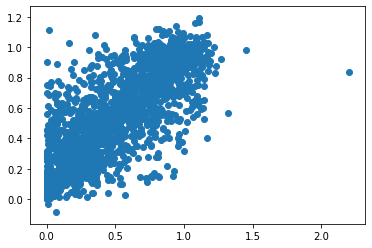

In [73]:
plt.scatter(valid[20], Y_hat[20]);

### Let's try excluding the inputs from the outputs 

In [94]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_idx], train[:, not_X])
    Y_hat = lasso_model.predict(valid[:, X_idx])
    valid_losses.append(mean_squared_error(Y_hat, valid[:, not_X]))

Computing validation loss for alpha = 0.001
Computing validation loss for alpha = 0.004105263157894737
Computing validation loss for alpha = 0.007210526315789474
Computing validation loss for alpha = 0.010315789473684212
Computing validation loss for alpha = 0.013421052631578948
Computing validation loss for alpha = 0.016526315789473684
Computing validation loss for alpha = 0.019631578947368424
Computing validation loss for alpha = 0.02273684210526316
Computing validation loss for alpha = 0.025842105263157895
Computing validation loss for alpha = 0.02894736842105263
Computing validation loss for alpha = 0.03205263157894737
Computing validation loss for alpha = 0.0351578947368421
Computing validation loss for alpha = 0.038263157894736846
Computing validation loss for alpha = 0.04136842105263158
Computing validation loss for alpha = 0.04447368421052632
Computing validation loss for alpha = 0.047578947368421054
Computing validation loss for alpha = 0.05068421052631579
Computing validation

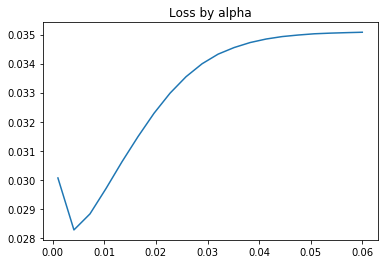

In [95]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [96]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

Create a lasso model using alpha = 0.004105263157894737


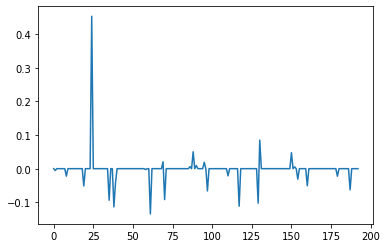

In [97]:
plt.plot(lasso_model.coef_[1])

0.0355232717631723


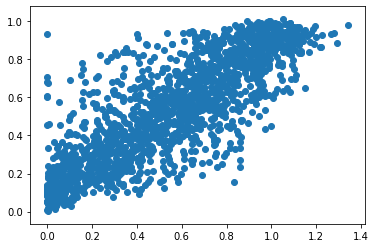

In [98]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))
plt.scatter(valid[3], Y_hat[3]);